# Unsupervised Learning with K-Means: A Step-by-Step Clustering Analysis of the Iris Dataset

### Goal
The primary goal of this project is to demonstrate the fundamental principles of **Unsupervised Machine Learning** using the classic Iris flower dataset. We will explore how algorithms can discover hidden structures and natural groupings within data without relying on pre-existing labels or categories.

### Learning Objectives

In this tutorial, we will first explore the dataset visually to build an intuition for how the data is distributed. We will then proceed to preprocess the data by standardizing features, ensuring that all variables contribute equally to the model's distance calculations. 

Following this, we will implement the **K-Means clustering algorithm**, using techniques like the Elbow Method to scientifically determine the optimal number of clusters. Finally, we will validate our unsupervised model by comparing its "blind" predictions against the actual known species of the flowers to assess accuracy and identify misclassifications.


### 1. Setup and Data Loading

We begin by importing the essential Python libraries for data manipulation (Pandas, NumPy) and visualization (Matplotlib, Seaborn). We also load the Iris dataset directly from Scikit-Learn's built-in library, which allows us to quickly access the data without external files.

Crucially, we separate the data into two parts: the **Input Features (X)**, which the model will use for learning, and the **Ground Truth Labels (y)**, which we will hide from the model. This simulates a true unsupervised environment where the algorithm must find patterns on its own, while allowing us to retain the answers for validation later.


In [1]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

sns.set_theme(style="whitegrid")

iris = datasets.load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

X = df.copy()

y_true = iris.target
species_names = iris.target_names

print("Input Features (X) - What the model sees:")
print(X.head())
print("\nGround Truth Labels (Hidden from model):")
print(y_true[:5])


Input Features (X) - What the model sees:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

Ground Truth Labels (Hidden from model):
[0 0 0 0 0]


### 2. Exploratory Data Analysis (EDA)

Before applying any machine learning algorithms, it is critical to visualize the data to understand its underlying structure. Here, we generate a **pairplot** to examine the relationships between all four features simultaneously. We color-code the points by their actual species to verify if natural groupings exist in the raw data.

From this visualization, you can observe that the **Setosa** species forms a distinct, isolated island that is easily separable. In contrast, the **Versicolor** and **Virginica** species show significant overlap, which suggests that distinguishing between these two groups will be the primary challenge for our clustering algorithm.


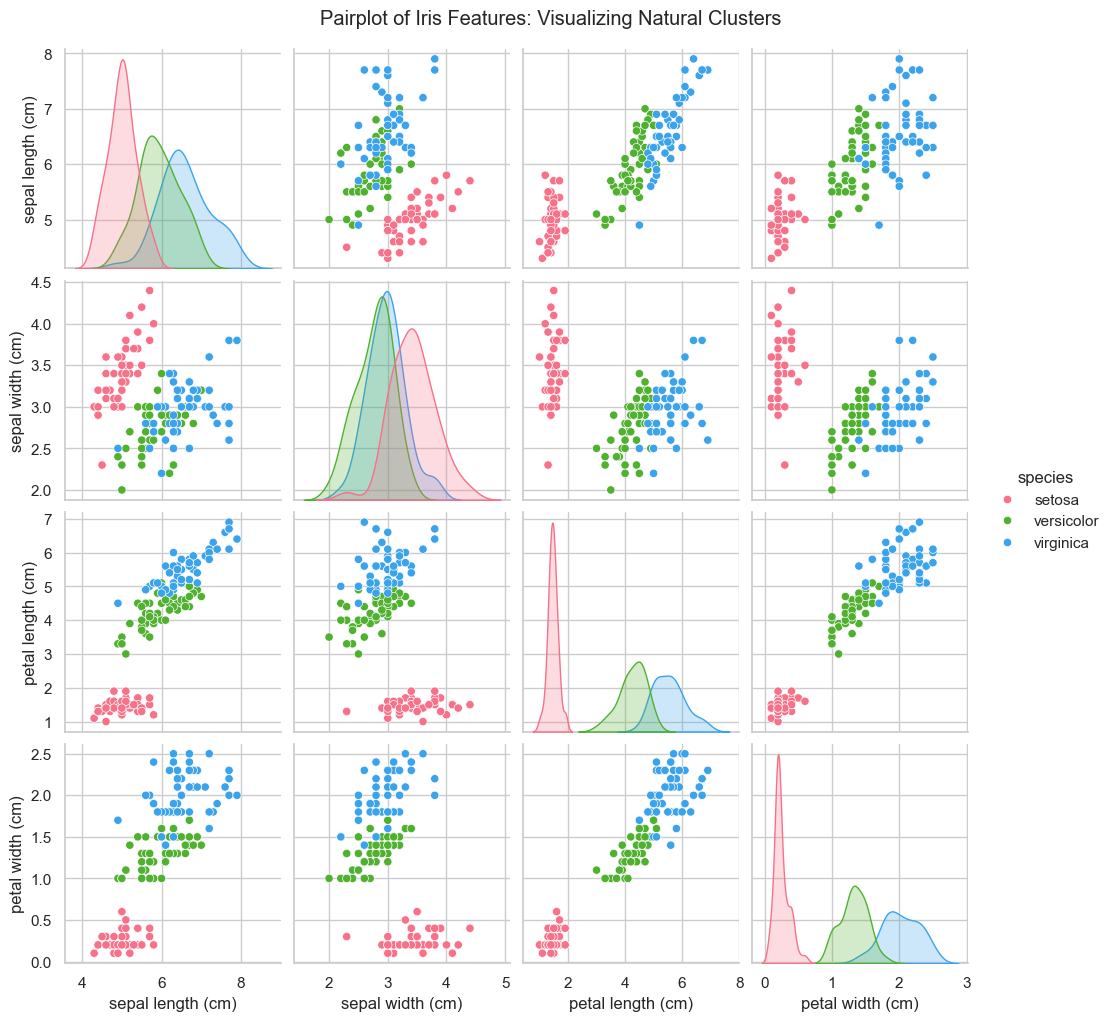

In [2]:
# 1. Prepare data for visualization
# We create a temporary DataFrame that includes the species names 
# so we can color-code the plot to build intuition.
df_viz = X.copy()
df_viz['species'] = [species_names[i] for i in y_true]

# 2. Create the Pairplot
# hue='species': colors the dots by their actual type
sns.pairplot(df_viz, hue='species', palette='husl', height=2.5)

# Adjust title position
plt.suptitle("Pairplot of Iris Features: Visualizing Natural Clusters", y=1.02)
plt.show()


### 3. Preprocessing: Feature Scaling

K-Means clustering relies heavily on Euclidean distance calculations, which makes it sensitive to the scale of the data. If one feature has a much larger range of values than another, it will disproportionately influence the final results, potentially distorting the clusters.

To prevent this, we apply **Feature Scaling** using the `StandardScaler`. This transforms all features to have a mean of 0 and a standard deviation of 1, placing them on a level playing field so the algorithm treats each variable with equal importance. The summary statistics below confirm that our data is now properly normalized.


In [3]:
from sklearn.preprocessing import StandardScaler

# 1. Initialize the Scaler
scaler = StandardScaler()

# 2. Fit and Transform the data
# We compute the mean and std dev (fit) and then scale the data (transform)
X_scaled = scaler.fit_transform(X)

# 3. Verify the scaling
# Convert back to DataFrame just for checking statistics
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Data Statistics AFTER Scaling:")
X_scaled_df.describe().round(2)


Data Statistics AFTER Scaling:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count             150.00            150.00             150.00   
mean               -0.00             -0.00              -0.00   
std                 1.00              1.00               1.00   
min                -1.87             -2.43              -1.57   
25%                -0.90             -0.59              -1.23   
50%                -0.05             -0.13               0.34   
75%                 0.67              0.56               0.76   
max                 2.49              3.09               1.79   

       petal width (cm)  
count            150.00  
mean              -0.00  
std                1.00  
min               -1.45  
25%               -1.18  
50%                0.13  
75%                0.79  
max                1.71  


### 4. Determining Optimal Clusters: The Elbow Method

In a true unsupervised setting, we do not know beforehand how many groups (or "clusters") exist in the data. To estimate the optimal number of clusters ($k$), we use a heuristic known as the **Elbow Method**. This approach involves running the K-Means algorithm multiple times with different values of $k$ and calculating the "Inertia" for each run.

Inertia, technically known as the **Within-Cluster Sum of Squares (WCSS)**, measures how compact the clusters are. It calculates the sum of the squared distances between every data point and its nearest cluster center. A lower inertia means the points are huddled closely around their centers, which is generally good. However, inertia naturally decreases as we add more clusters; in the extreme case where every point is its own cluster, inertia drops to zero.

> The key intuition is to find the point of "diminishing returns."

We look for the "elbow" in the plot; the point where adding another cluster no longer significantly reduces the inertia. This inflection point suggests a balance where the model fits the data well without becoming overly complex or fragmented.


Running K-Means for k=1 to 10...


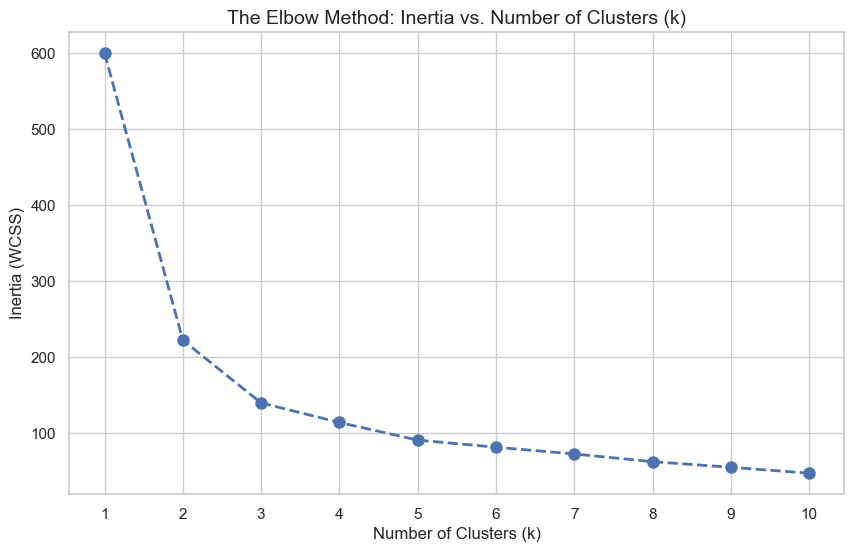

In [4]:
from sklearn.cluster import KMeans

# 1. Calculate Inertia for a range of k values
inertia_values = []
k_range = range(1, 11)

print("Running K-Means for k=1 to 10...")

for k in k_range:
    # Initialize K-Means
    # n_init=10 runs the algo 10 times with different centroids to find the best start
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Fit on the SCALED data
    kmeans.fit(X_scaled)
    
    # Append the inertia (Within-Cluster Sum of Squares)
    inertia_values.append(kmeans.inertia_)

# 2. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o', linestyle='--', linewidth=2, markersize=8)
plt.title('The Elbow Method: Inertia vs. Number of Clusters (k)', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (WCSS)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()



### 5. Validation: Silhouette Score Analysis

While the Elbow Method provides a visual estimate, the **Silhouette Score** offers a more objective, mathematical metric to validate the quality of our clustering. It measures how similar a data point is to its own cluster (cohesion) compared to other clusters (separation). The score ranges from -1 to +1, where a high value indicates that points are well-matched to their own cluster and poorly matched to neighboring clusters.

Interestingly, you may notice that $k=2$ yields the highest mathematical score here. This occurs because the Virginica and Versicolor species overlap significantly, causing the algorithm to view them as a single, large "blob" mathematically. However, the score for $k=3$ remains strong (approx 0.46), confirming that a 3-cluster solution is also a valid and robust interpretation of the data structure.


Calculating Silhouette Scores...
k=2: Silhouette Score = 0.582
k=3: Silhouette Score = 0.460
k=4: Silhouette Score = 0.387
k=5: Silhouette Score = 0.346


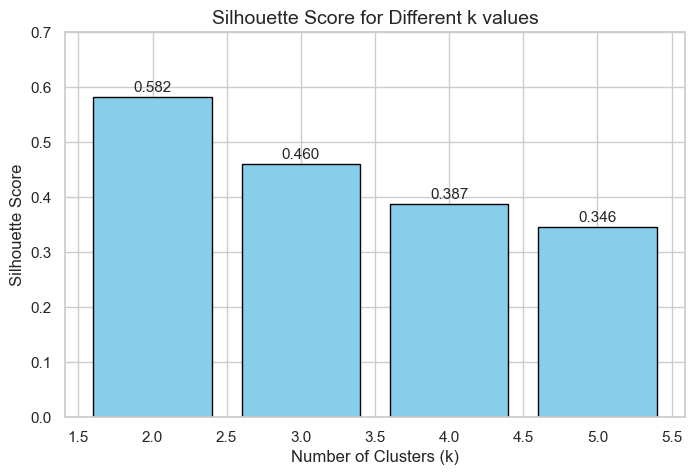

In [28]:
from sklearn.metrics import silhouette_score

# 1. Define the range of k values to test
# We start from k=2 because silhouette score requires at least 2 clusters to calculate separation
k_values_to_test = [2, 3, 4, 5]
sil_scores = []

print("Calculating Silhouette Scores...")

for k in k_values_to_test:
    # Initialize and fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    # Calculate Silhouette Score
    # This metric computes (separation - cohesion) / max(separation, cohesion)
    # Range: -1 (wrong clustering) to +1 (perfect clustering)
    score = silhouette_score(X_scaled, kmeans.labels_)
    sil_scores.append(score)
    
    print(f"k={k}: Silhouette Score = {score:.3f}")

# 2. Visualize the Scores
plt.figure(figsize=(8, 5))
plt.bar(k_values_to_test, sil_scores, color='skyblue', edgecolor='black')
plt.title('Silhouette Score for Different k values', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.ylim(0, 0.7)  # Set limit to make differences visible
for i, v in enumerate(sil_scores):
    plt.text(k_values_to_test[i], v + 0.01, f"{v:.3f}", ha='center', fontsize=11)
plt.show()

### 6. Model Fitting and Label Assignment

Armed with the insights from our analysis, we now proceed to instantiate and train the final K-Means model using our chosen value of $k=3$. The model is fitted on the scaled dataset, allowing it to determine the optimal positions for the three cluster centroids.

Upon completion, the algorithm assigns each data point (flower) to one of the three clusters. These assignments are stored as integer labels (0, 1, or 2), which we append to our original dataframe in a new `cluster_label` column. It is crucial to remember that these labels are arbitrary; the model does not know which cluster corresponds to which species, only that it has found three distinct groups.


In [6]:
# Initialize the Final Model with k=3
final_kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Fit the model to the SCALED data
final_kmeans.fit(X_scaled)

# We create a new column 'cluster_label' to store the model's predictions
df['cluster_label'] = final_kmeans.labels_

# Show a sample of how the data looks now with the new labels
print("Dataframe with Assigned Clusters:")
print(df[['sepal length (cm)', 'petal length (cm)', 'cluster_label']].sample(10, random_state=42))




Dataframe with Assigned Clusters:
     sepal length (cm)  petal length (cm)  cluster_label
73                 6.1                4.7              0
18                 5.7                1.7              1
118                7.7                6.9              2
78                 6.0                4.5              0
76                 6.8                4.8              2
31                 5.4                1.5              1
64                 5.6                3.6              0
141                6.9                5.1              2
68                 6.2                4.5              0
82                 5.8                3.9              0


### 7. Ground Truth Evaluation: The Confusion Matrix

Finally, we assess the performance of our unsupervised model by comparing its "blind" predictions against the actual species labels—information the model never saw during training. We use a **Confusion Matrix** (visualized here as a heatmap) to cross-tabulate the predicted clusters against the true species.

To make the evaluation intuitive, we dynamically reorder the matrix columns to align each cluster with the species it most likely represents. The diagonal cells (dark blue) represent correct classifications, while the off-diagonal cells indicate errors. You will typically observe that the algorithm separates Setosa perfectly (100% accuracy), but shows some confusion between Versicolor and Virginica, reflecting the natural biological overlap we identified in our initial data exploration.


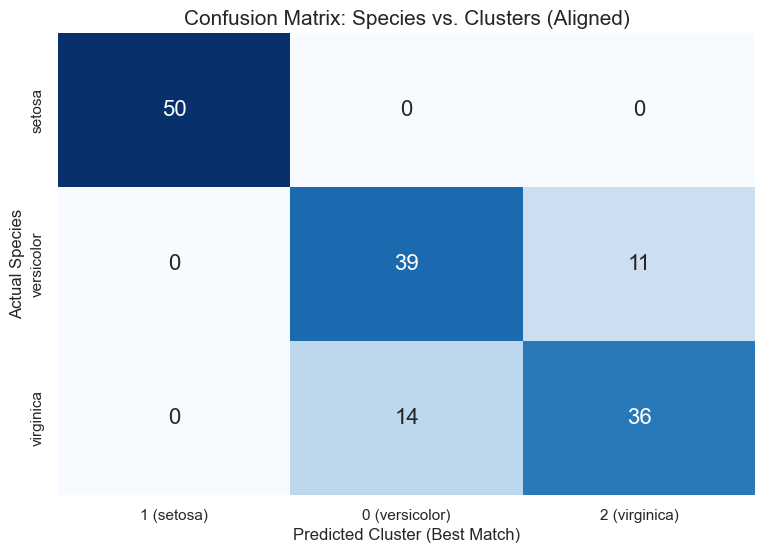

In [8]:

# Add the 'species_name' column to the dataframe 
df['species_name'] = [species_names[i] for i in y_true]

ct = pd.crosstab(
    df['species_name'], 
    df['cluster_label'], 
    rownames=['Actual Species'], 
    colnames=['Predicted Cluster']
)

# 2. Reorder Columns to match the Diagonal (Greedy Matching)
# We want the column for 'setosa' to be the one where 'setosa' has the highest count, etc.
# This aligns the clusters to the species they represent best.
id_max = ct.idxmax(axis=1) # Find which cluster is the "winner" for each species
ct_ordered = ct[id_max.values] # Reorder columns based on that winner

# Rename columns to show the mapping (e.g., "0 (Setosa)")
new_columns = [f"{col} ({species})" for species, col in id_max.items()]
ct_ordered.columns = new_columns

# 3. Visualize with Heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(ct_ordered, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix: Species vs. Clusters (Aligned)', fontsize=15)
plt.ylabel('Actual Species')
plt.xlabel('Predicted Cluster (Best Match)')
plt.show()



### 8. Visualization: Dimensionality Reduction with PCA

A major challenge in machine learning is visualizing high-dimensional data. The Iris dataset contains **4 features** (sepal length, sepal width, petal length, petal width), but our screens can only show 2 dimensions (or 3, if we rotate a 3D plot). We cannot simply discard two features, as we would lose critical information.

To solve this, we use **Principal Component Analysis (PCA)**. PCA transforms the original features into a new set of "Principal Components" that are linear combinations of the originals. These components are ranked:
- **PC1** captures the most variation in the data (the "longest" axis).
- **PC2** captures the second most variation.

By plotting only PC1 vs. PC2, we flatten the 4D data into a 2D map while preserving as much of the original structure and distance relationships as possible. This allows us to visually inspect the "territories" of our clusters and verify that the algorithm has drawn reasonable decision boundaries.


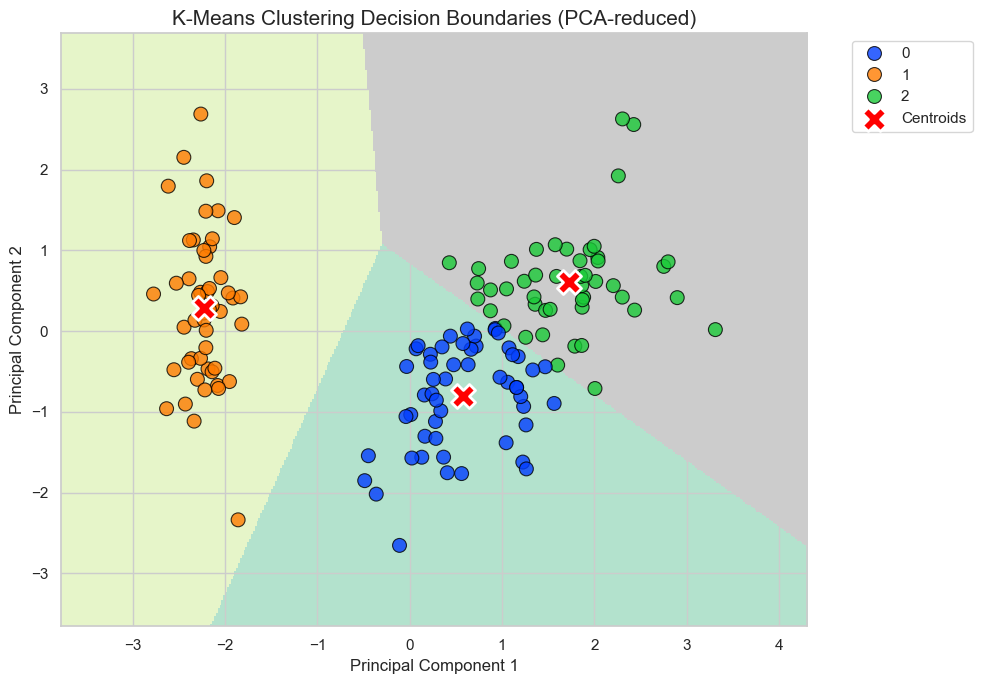

In [7]:
from sklearn.decomposition import PCA

# 1. Reduce Dimensions to 2D for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Store PCA results in the dataframe for plotting
df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]

# Get the centroids and transform them to PCA space too (so we can plot them)
centroids_pca = pca.transform(final_kmeans.cluster_centers_)

# 2. Create the Decision Boundary Background
# We create a fine grid of points across the whole 2D space
h = 0.02  # Step size of the mesh
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict cluster for every point in the background grid
# Note: We must inverse_transform PCA points back to 4D to let K-Means predict them
Z = final_kmeans.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# 3. Plotting
plt.figure(figsize=(10, 7))

# A. Draw the colored regions (Decision Boundaries)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Pastel2, # Soft pastel background
           aspect='auto', origin='lower')

# B. Draw the data points (Flowers)
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster_label', 
                data=df, palette='bright', s=100, edgecolor='black', alpha=0.8)

# C. Draw the Centroids (Centers)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            s=300, c='red', marker='X', label='Centroids', edgecolors='white', linewidth=2)

plt.title('K-Means Clustering Decision Boundaries (PCA-reduced)', fontsize=15)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 9. Error Analysis: Visualizing Misclassifications

While the clustering looked distinct in the previous step, it's essential to understand *where* the model struggled. Since K-Means does not know the true labels (Setosa, Versicolor, Virginica), it simply groups similar points. To evaluate errors, we must first "align" our cluster numbers (0, 1, 2) to the species they best represent by finding the most common species in each cluster.

In the plot below, we visualize this alignment. 
- **Circles** represent flowers that were correctly grouped into their dominant species cluster.
- **Crosses (X)** represent "misclassified" flowers, that is, points that mathematically fit better in one cluster but biologically belong to another species.

Notice that the **Setosa** group (far left) is perfect; no crosses. The errors are concentrated exclusively on the boundary between **Versicolor** and **Virginica**, visually confirming that these two species are naturally harder to distinguish using only petal and sepal measurements.


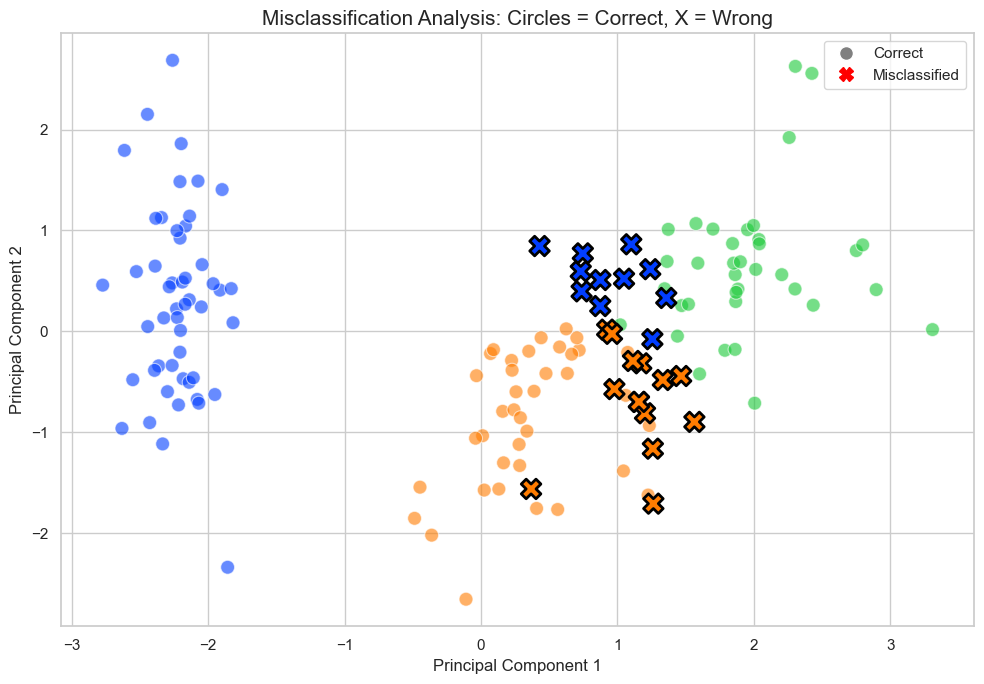

In [9]:
# 1. Map Clusters to Species Logic
from scipy.stats import mode

labels_map = {}
for i in range(3):
    mask = (final_kmeans.labels_ == i)
    # Use mode().mode[0] to handle different scipy versions safely
    most_common_species = mode(y_true[mask], keepdims=True).mode[0]
    labels_map[i] = most_common_species

# Create 'aligned' predictions
y_pred_aligned = np.array([labels_map[label] for label in final_kmeans.labels_])

# 2. Identify Misclassified Points
is_wrong = (y_pred_aligned != y_true)
df['is_wrong'] = is_wrong
df['species_name'] = [species_names[i] for i in y_true]

# 3. Plotting Errors
plt.figure(figsize=(10, 7))

# Plot CORRECT points as Circles (o)
# We remove 'style' and just set marker='o' directly
sns.scatterplot(
    x='pca_1', y='pca_2', 
    data=df[~df['is_wrong']], 
    hue='species_name', 
    marker='o',          # <--- FIXED: Set marker directly
    palette='bright', 
    s=100, 
    alpha=0.6,
    legend=False
)

# Plot WRONG points as X's
sns.scatterplot(
    x='pca_1', y='pca_2', 
    data=df[df['is_wrong']], 
    hue='species_name',
    marker='X',          # <--- FIXED: Set marker directly
    palette='bright', 
    s=200, 
    linewidth=2,
    edgecolor='black',
    legend=False         # We will build a custom legend below
)

plt.title('Misclassification Analysis: Circles = Correct, X = Wrong', fontsize=15)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Custom legend
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Correct'),
    Line2D([0], [0], marker='X', color='w', markeredgecolor='red', markerfacecolor='red', markersize=10, label='Misclassified')
]
plt.legend(handles=custom_lines, loc='upper right')

plt.tight_layout()
plt.show()


# Conclusion

In this project, we successfully demonstrated an end-to-end unsupervised learning workflow using the Iris dataset.

1.  **Exploration**: We confirmed visually that "Setosa" is naturally distinct, while "Versicolor" and "Virginica" share significant overlap.
2.  **Preprocessing**: We standardized the data to ensure fair distance calculations.
3.  **Modeling**: We used the Elbow Method and Silhouette Scores to determine that $k=3$ was indeed the optimal number of clusters, matching the known biological truth.
4.  **Evaluation**: Our final K-Means model achieved near-perfect separation for Setosa (100% accuracy) but naturally struggled with the borderline cases between Versicolor and Virginica.

This exercise highlights a key lesson in machine learning: **Models can discover structure blindly, but their performance is ultimately bounded by the separability of the underlying data.** K-Means did an excellent job, but no distance-based algorithm could perfectly separate the overlapping species without more complex features or non-linear boundaries.
